#### Installing Unsloth

In [1]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl==0.15.2 triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
    !pip install --no-deps unsloth

#------THIS PROJECT WAS RUN ON COLAB TO MAKE USE OF THE A100 GPU, ANY PATHS MENTIONED HAVE TO BE CHANGED ACCORDINGLY---"

#### Loading the Llama model

We use ``FastLanguageModel`` from unsloth

In [2]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 512 # chosen for optimum results and training time
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models
fourbit_models = [
    "unsloth/Meta-Llama-3.1-8B-bnb-4bit",      # Llama-3.1 2x faster
    "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    "unsloth/Meta-Llama-3.1-70B-bnb-4bit",
    "unsloth/Meta-Llama-3.1-405B-bnb-4bit",    # 4bit for 405b!
    "unsloth/Mistral-Small-Instruct-2409",     # Mistral 22b 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/Phi-3.5-mini-instruct",           # Phi-3.5 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/gemma-2-9b-bnb-4bit",
    "unsloth/gemma-2-27b-bnb-4bit",            # Gemma 2x faster!

    "unsloth/Llama-3.2-1B-bnb-4bit",           # NEW! Llama 3.2 models
    "unsloth/Llama-3.2-1B-Instruct-bnb-4bit",
    "unsloth/Llama-3.2-3B-bnb-4bit",
    "unsloth/Llama-3.2-3B-Instruct-bnb-4bit",

    "unsloth/Llama-3.3-70B-Instruct-bnb-4bit" # NEW! Llama 3.3 70B!
]

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Llama-3.2-1B-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,

)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.4.7: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/1.03G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/230 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

Inject with LoRA

In [3]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # 0 is optimized
    bias = "none",    # "none" is optimized
    # "unsloth" uses 30% less VRAM, fits 2x larger batch sizes
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # rank stabilized LoRA is set to false
    loftq_config = None,
)

Unsloth 2025.4.7 patched 16 layers with 16 QKV layers, 16 O layers and 16 MLP layers.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

# ----WE MOUNT OUR OWN DRIVE WHERE WE SAVED THE ADAPTER WEIGHTS-----#

Mounted at /content/drive


#### Load the dataset

Make sure the ```txt_path``` contains the ```finance_corpus.txt`` file. Since we have used a colab file it was saved on drive for us. **`dataset/finance_corpus.txt`** contains the necessary file.

In [6]:
from datasets import load_dataset
txt_path = '/content/drive/MyDrive/HPML_Project/dataset/finance_corpus.txt'

# load the finance_corpus.txt
ds = load_dataset(
    "text",
    data_files={"train": txt_path},
    split="train",
)
ds = ds.filter(lambda x: x["text"].strip() != "")

print(f"Loaded {len(ds)} examples; sample text:")
print(ds[0]["text"][:200].replace("\n"," "), "…")

Generating train split: 0 examples [00:00, ? examples/s]

Filter:   0%|          | 0/441891 [00:00<?, ? examples/s]

Loaded 227699 examples; sample text:
Article 1: Warren Buffett Autographed Books To Help Charity: Here's How You Can Get Legendary Investor's Signature …


In [7]:
split = ds.train_test_split(test_size=0.10, seed=42)
train_ds = split["train"]
val_ds   = split["test"]

In [8]:
import re
from datasets import Dataset

articles, buf = [], []

with open(txt_path, encoding="utf‑8") as f:
    for line in f:
        # new article header
        if re.match(r"^Article\s+\d+:", line):
            if buf:
                articles.append(" ".join(buf).strip())
                buf = []
        buf.append(line.strip())
    if buf:
        articles.append(" ".join(buf).strip())

print("Total articles:", len(articles))
ds = Dataset.from_dict({"text": articles})

Total articles: 9285


In [9]:
split = ds.train_test_split(test_size=0.10, seed=42)
train_ds = split["train"]
val_ds   = split["test"]

In [10]:
train_ds

Dataset({
    features: ['text'],
    num_rows: 8356
})

In [11]:
for text in ds["text"][:10]:
    toks = tokenizer(text, add_special_tokens=False)
    print(len(toks["input_ids"]), "tokens")

670 tokens
799 tokens
696 tokens
554 tokens
797 tokens
813 tokens
728 tokens
757 tokens
962 tokens
974 tokens


In [12]:
from transformers import TrainerCallback
import math

class PerplexityCallback(TrainerCallback):
    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics is not None and "eval_loss" in metrics:
            ppl = math.exp(metrics["eval_loss"])
            print(f"Eval perplexity: {ppl:.2f}")

#### Training

In [13]:
from trl import SFTTrainer
from transformers import TrainingArguments, DataCollatorForSeq2Seq, DataCollatorForLanguageModeling
from unsloth import is_bfloat16_supported

NUM_EPOCHS = 10

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_ds,
    eval_dataset     = val_ds,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    torch_compile = True,
    torch_compile_backend = "inductor",
    torch_compile_mode    = "reduce-overhead",

    # data_collator = DataCollatorForSeq2Seq(tokenizer = tokenizer),
    data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False),
    callbacks = [PerplexityCallback()],
    dataset_num_proc = 2,
    packing = True, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 32,
        gradient_accumulation_steps = 1,
        warmup_steps = 5,
        num_train_epochs = NUM_EPOCHS,
        # max_steps = 60,
        eval_strategy = "epoch",
        learning_rate = 2e-5,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 5,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # dont report to wandb, its asks for api key lol
    ),
)

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/8356 [00:00<?, ? examples/s]

Unsloth: Hugging Face's packing is currently buggy - we're disabling it for now!


Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/929 [00:00<?, ? examples/s]

Unsloth: Hugging Face's packing is currently buggy - we're disabling it for now!


In [14]:
tokenizer.decode(trainer.train_dataset[0]["input_ids"])

'<|begin_of_text|>Article 3263: Breaking News: Dow, S&amp;P, Nasdaq Futures Tumble Ahead of Big Earnings Week  April 21 - U.S. equity futures declined on Monday, as investors returned from the holiday weekend facing renewed concerns over U.S.-China trade tensions and a packed earnings calendar.  Nasdaq 100 futures slid about 1.2%, while Dow Jones Industrial Average and S&P 500 futures dropped nearly 0.9% and 1.1%, respectively. The three major indices also ended last week lower, notching their third loss in four weeks.  Weighing on sentiment was UnitedHealth (NYSE:UNH), which fell more than 22% on Thursday after cutting its full-year outlook and reporting underwhelming earnings. In contrast, Eli Lilly (NYSE:LLY) surged 14% following positive late-stage trial results for its experimental weight loss drug, orforglipron.  The ongoing lack of progress in direct U.S.-China trade talks, along with comments from Chicago Fed President Austan Goolsbee warning of potential economic slowdown from

In [15]:
trainer.train_dataset

Dataset({
    features: ['text', 'input_ids', 'attention_mask'],
    num_rows: 8356
})

#### Memory stats before training

In [16]:
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA A100-SXM4-40GB. Max memory = 39.557 GB.
1.457 GB of memory reserved.


In [17]:
import time

# Estimate total tokens
num_tokens = len(trainer.train_dataset) * max_seq_length * NUM_EPOCHS

start = time.time()
trainer_stats = trainer.train()
end = time.time()

elapsed = end - start
throughput = num_tokens / elapsed

print(f"Throughput: {throughput:.2f} tokens/sec")

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 8,356 | Num Epochs = 10 | Total steps = 2,620
O^O/ \_/ \    Batch size per device = 32 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (32 x 1 x 1) = 32
 "-____-"     Trainable parameters = 11,272,192/1,000,000,000 (1.13% trained)


Unsloth: Enabled auto compiling


Epoch,Training Loss,Validation Loss
1,2.138800,2.121581
2,1.971200,2.005857
3,1.891100,1.946934
4,1.835100,1.912870
5,1.853900,1.889571
6,1.823500,1.873433
7,1.748000,1.861301
8,1.642100,1.853742
9,1.834100,1.848963
10,1.853000,1.847494


Unsloth: Will smartly offload gradients to save VRAM!
Eval perplexity: 8.34
Eval perplexity: 7.43
Eval perplexity: 7.01
Eval perplexity: 6.77
Eval perplexity: 6.62
Eval perplexity: 6.51
Eval perplexity: 6.43
Eval perplexity: 6.38
Eval perplexity: 6.35
Eval perplexity: 6.34
Throughput: 17533.92 tokens/sec


#### Memory usage after training

In [20]:
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

Peak reserved memory = 3.557 GB.
Peak reserved memory for training = 2.1 GB.
Peak reserved memory % of max memory = 8.992 %.
Peak reserved memory for training % of max memory = 5.309 %.


As you can see qLORA helped us save memory on the A100

#### Loss Statistics

We evaluate the training and validation loss 

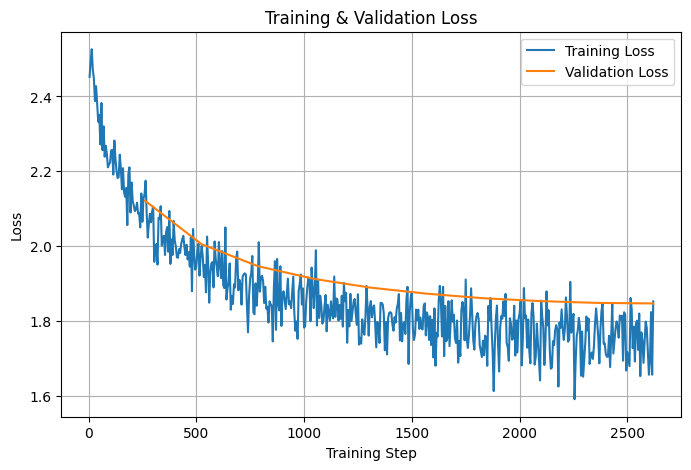

In [22]:
history = trainer.state.log_history

# training‐loss
train_steps  = [x["step"]        for x in history if "loss" in x and "eval_loss" not in x]
train_loss   = [x["loss"]        for x in history if "loss" in x and "eval_loss" not in x]

# validation‐loss
eval_steps   = [x["step"]        for x in history if "eval_loss" in x]
eval_loss    = [x["eval_loss"]   for x in history if "eval_loss" in x]

# plot
plt.figure(figsize=(8,5))
plt.plot(train_steps, train_loss, label="Training Loss")
plt.plot(eval_steps,  eval_loss,  label="Validation Loss")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [23]:
FastLanguageModel.for_inference(model)

def answer(prompt: str,
           max_new_tokens: int = 128,
           temperature: float    = 0.2,
           top_p: float          = 0.7,
           repetition_penalty: float = 1.2,
           no_repeat_ngram_size: int = 3):
    # tokenize
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=512
    ).to(model.device)

    input_ids = inputs["input_ids"]

    # generate
    outputs = model.generate(
        **inputs,
        max_new_tokens       = max_new_tokens,
        temperature          = temperature,
        top_p                = top_p,
        do_sample            = True,
        repetition_penalty   = repetition_penalty,
        no_repeat_ngram_size = no_repeat_ngram_size,
        eos_token_id         = tokenizer.eos_token_id,
        pad_token_id         = tokenizer.pad_token_id,
        early_stopping       = True,
    )

    # strip off prompt‐tokens and decode the new ones
    gen_ids = outputs[0][ input_ids.shape[-1] : ]
    return tokenizer.decode(gen_ids, skip_special_tokens=True).strip()


print(answer("How is starbucks doing?"))

Starbucks Corporation (NASDAQ:SBUX) has seen its share price fall by 11% over the last month, which may not be a good sign for investors. However, it's important to consider whether this decline was caused by fundamental changes in sentiment towards the company or if there are other factors at play. In that case, we might want to take another look at what these events mean for shareholders and how they could affect their investment returns.
Check out our latest analysis on Starbucks' financial health NasdaqGS:SBBU Historical Data March 29th 2025
What Does The Fundamentals Look Like For SBUX?
The


This is where you save the adapters and tokenizer files. Make sure you are mindful of the path you are saving it to

In [24]:
#------ADD YOUR OWN PATH-----#
save_path = "/content/drive/MyDrive/HPML_Project/copy_unsloth_a100_8"
#------MAKE SURE WHILE RUNNING YOU KEEP A TRACK OF WHERE YOU ARE SAVING IT----#

# Save LoRA adapter + config
trainer.save_model(save_path)

# Save tokenizer files
tokenizer.save_pretrained(save_path)

print(" Saved adapters + tokenizer to", save_path)

 Saved adapters + tokenizer to /content/drive/MyDrive/HPML_Project/copy_unsloth_a100_8


## Inference


If you just want to run inference (which you would want to ideally as training on the A100 will still take 40 minutes) make sure you download the adapter weights and then use 

**"llama_finetune/adapter_weights/copy_unsloth_a100_8"** 

folder as your path.


In [4]:
import torch
from peft import prepare_model_for_kbit_training, PeftModel
from unsloth import FastLanguageModel

# Load the same 4-bit base + tokenizer we fine-tuned on
base, tokenizer = FastLanguageModel.from_pretrained(
    model_name     = "unsloth/Llama-3.2-1B-bnb-4bit",  # base
    max_seq_length = 128,
    dtype          = None,                   # or None for auto
    load_in_4bit   = True,
    device_map     = "auto",
)

# ensure pad/eos tokens are set
tokenizer.pad_token = tokenizer.eos_token
base.config.pad_token_id = tokenizer.pad_token_id
base.config.use_cache      = True

# Patch for QLoRA / k-bit adapters
base = prepare_model_for_kbit_training(base)

# Load your fine-tuned LoRA adapters
#-----THIS IS WHERE YOU PUT save_path AS THE FOLDER WHERE YOU SAVED THE WEIGHTS----#
model = PeftModel.from_pretrained(
    base,
    save_path,     # folder where we saved adapters + tokenizer
    device_map="auto",          # shard onto GPU automatically
)

# model.eval()
FastLanguageModel.for_inference(model)

# Inference helper
def answer(prompt: str,
           max_new_tokens: int = 128,
           temperature: float    = 0.2,
           top_p: float          = 0.7,
           repetition_penalty: float = 1.2,
           no_repeat_ngram_size: int = 3):
    # tokenize
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=512
    ).to(model.device)

    input_ids = inputs["input_ids"]

    # generate
    outputs = model.generate(
        **inputs,
        max_new_tokens       = max_new_tokens,
        temperature          = temperature,
        top_p                = top_p,
        do_sample            = True,
        repetition_penalty   = repetition_penalty,
        no_repeat_ngram_size = no_repeat_ngram_size,
        eos_token_id         = tokenizer.eos_token_id,
        pad_token_id         = tokenizer.pad_token_id,
        early_stopping       = True,
    )

    # strip off prompt‐tokens and decode only the new ones
    gen_ids = outputs[0][ input_ids.shape[-1] : ]
    return tokenizer.decode(gen_ids, skip_special_tokens=True).strip()




==((====))==  Unsloth 2025.4.7: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Testing with a few prompts

In [5]:
print(answer("How is starbucks stock doing?"))

Starbucks (SBUX) shares are trading higher today after the company reported better-than-expected first-quarter earnings and issued a strong outlook for fiscal 2025. The coffee giant’s revenue rose by nearly 10% year over year, while its adjusted profit climbed to $1.7 billion from $2.3 billion in the same period last year.
The results were driven largely by robust sales growth across all regions of the world except China where it saw an unexpected decline due to currency headwinds. However, this was offset partially by lower margins as operating expenses increased slightly compared with prior-year levels. This suggests that management may have been


In [6]:

print(answer("What is the best performing stock?"))

What are some of the most popular stocks to invest in right now?
The answer depends on your perspective. If you’re looking for a high-performing stock, then any company that’s growing its earnings at or above 20% per year will do nicely.
If you want something more specific than just growth, though, there may be other factors worth considering as well. For example: if you like companies with strong cash flow and low debt levels (which can help protect against economic downturns), then look into tech giants such as Apple Inc., Microsoft Corp., Amazon.com Inc., Alphabet Inc.’s Google Cloud Platform unit, Meta Platforms Inc


In [7]:
print(answer("What is the news on Lockheed Martin?"))

The company has been in a bit of an uproar lately, with investors concerned about its future and potential earnings. Recently, however, there was some good news for shareholders as it announced that it had reached agreements to sell two F-35 fighter jets worth $1 billion each.
This move could be seen by many analysts as positive because these aircraft are crucial components of America’s military arsenal. They help protect our country from any threats or attacks coming across oceans far away from us. This means they will now have more time available during their production process which can only benefit them financially over longer periods due to reduced costs associated with maintenance repairs etceter
